In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta

In [3]:
import sys
import os.path
# Local Modules
# sys.path.insert(0, os.path.abspath('/scratch/horta/coronawiki/'))
from helpers.load import load_interventions, load_aggregated, load_topics
from helpers.vars import codes, helper_langs, interventions_helper, int_c, int_ls
from helpers.plot import set_size, plot_dates, plot_intervention, plot_cumm_diff
from helpers.changepoints import *

In [4]:
# Latex Configuration
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib as mpl
# fontpath = os.path.expanduser('~/LinLibertine_DRah.ttf')
# prop = font_manager.FontProperties(fname=fontpath)

params = {
    "axes.titlesize" : 14,
    'axes.labelsize': 14,
    'font.size': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
#     'font.family': 'Linux Libertine Display',
    'text.usetex': True
}

mpl.rcParams.update(params)

In [5]:
google_mobility = pd.read_csv('../data/Global_Mobility_Report.csv.gz', compression="infer")
apple_mobility = pd.read_csv('../data/applemobilitytrends-2020-04-20.csv.gz', compression="infer")
interventions = load_interventions()

/Users/horta/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
mobility_data = {}
for lang_code in codes:
    print(lang_code)
    google_code = codes[lang_code]['google']
    apple_code = codes[lang_code]['apple']
    
    dfs = []
    if google_code:
        df_google = preprocess_google_mobility(google_mobility, google_code)
        dfs.append(df_google)
        
    if apple_code:
        df_apple = preprocess_apple_mobility(apple_mobility, apple_code)
        df_apple.index = pd.to_datetime(df_apple.index)
        dfs.append(df_apple)
    
    if len(dfs) == 2:
        df = pd.concat(dfs, axis=1)
    else:
        df = dfs[0]
    
    mobility_data[lang_code] = normalize_time_series(df)

it
fra
ger
da
us
fi
ja
ko
nl
no
sr
sv
can
sw
aus
nz
uk
at
za
ie
cm
be
ci
sn
bj


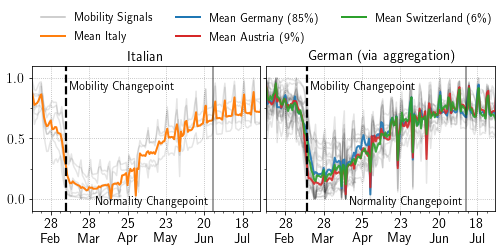

In [7]:

fig_size = (7, 3.5)
fig, axes = plt.subplots(1, 2, figsize=fig_size,
                        gridspec_kw={"wspace": 0.025}, sharey=True)

## PLOT ITALIAN
df = mobility_data['it']

ax = axes[0]
change_point = change_points['it']
normalcy = interventions["it"]["Normalcy"]

mean_df = df.mean(axis=1)
std_df = df.std(axis=1)
    
ax = df.plot(color='black', alpha=0.1, legend=False, ax = ax)
mean_df.plot(color='tab:orange', style='-', lw=2, legend=False, ax=ax)
ax.axvline(change_point, color='black', lw=2.2, linestyle="--")
ax.axvline(normalcy, color='black', lw=1.5, linestyle="-", alpha=0.5)
ax.text(change_point + relativedelta(days=3), 0.9, "Mobility Changepoint", 
        ha="left", size=12)
ax.text(normalcy - relativedelta(days=3), -0.05, 
        "Normality Changepoint", 
        ha="right", size=12)

ax.set_title("Italian")


# PLOT GERMAN

ax = axes[1]
change_point = change_points['de']
normalcy = interventions["de"]["Normalcy"]

# , change_point.strftime('%Y-%m-%d')
germany = mobility_data['ger']
austria = mobility_data['at']
switzerland = mobility_data['sw']

germany_mean = germany.mean(axis=1)
austria_mean = austria.mean(axis=1)
switzerland_mean = switzerland.mean(axis=1)

ax = germany.plot(color='black', alpha=0.1, legend=False, ax = ax)
ax = austria.plot(color='black', alpha=0.1, legend=False, ax = ax)
ax = switzerland.plot(color='black', alpha=0.1, legend=False, ax = ax)

ax = germany_mean.plot(color='tab:blue', style='-', lw=2, alpha=0.9, legend=False, ax = ax)
ax = austria_mean.plot(color='tab:red', style='-', lw=2, alpha=0.9, legend=False, ax = ax)
ax = switzerland_mean.plot(color='tab:green', style='-', lw=2, alpha=0.9, legend=False, ax = ax)

ax.axvline(change_point, color='black', lw=2.2, linestyle="--")
ax.axvline(normalcy, color='black', lw=1.5, linestyle="-", alpha=0.5)

ax.text(change_point + relativedelta(days=3), 0.9, 
        "Mobility Changepoint", 
        ha="left", size=12)

ax.text(normalcy - relativedelta(days=3), -0.05, 
        "Normality Changepoint", 
        ha="right", size=12)

ax.set_title('German (via aggregation)')




lines = [
        Line2D([0], [0], color='gray', alpha=0.5, linestyle='-'),
        Line2D([0], [0], color='tab:orange', linewidth=2, linestyle='-'),
        Line2D([0], [0], color='tab:blue', linewidth=2, linestyle='-'),
        Line2D([0], [0], color='tab:red', linewidth=2, linestyle='-'),
        Line2D([0], [0], color='tab:green', linewidth=2, linestyle='-')
]
lines_labels = ['Mobility Signals', 'Mean Italy',
                'Mean Germany ({}\%)'.format(int(100*pop_to_weights(de_pop)['ger'])), 
                'Mean Austria ({}\%)'.format(int(100*pop_to_weights(de_pop)['at'])+1), 
                'Mean Switzerland ({}\%)'.format(int(100*pop_to_weights(de_pop)['sw']))]
axes[1].legend(lines, lines_labels, ncol=3, loc='upper center', bbox_to_anchor=(0, 1.45), frameon=False, fontsize=12)

months_fmt = mdates.DateFormatter('%d\n%b')
day_fmt = mdates.DateFormatter('')
for ax in axes:
    ax.xaxis.set_major_formatter(months_fmt)
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator(interval=1))
    ax.xaxis.set_minor_formatter(day_fmt)
    ax.set_xlim([pd.to_datetime("2020-02-15"), pd.to_datetime("2020-07-31")])
    ax.grid(ls=":")
    ax.set_ylim([-0.1, 1.1])
    ax.set_yticks([0, 0.5, 1])
    ax.set_xlabel('')


set_size(fig, fig_size)
fig.savefig("../images/changepoint_example.pdf", bbox_inches="tight")

---